In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [2]:
# File path
file_path = "cleaned_coin_Bitcoin.csv"

# Load dataset
df = pd.read_csv(file_path)

# If your data has a date column, sort by date (adjust the column name if needed)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)

# Display first few rows
df.head()


,Date,High,Low,Open,Close,Volume,Marketcap,Daily Return,50-Day MA,200-Day MA,Price Diff,Volatility,Open-Close Diff,High-Low Range
0,2017-04-01 23:59:59,1091.719971,1061.089966,1071.709961,0.014250,0.000825,1.755760e+10,0.473962,0.016097,0.016478,0.002301,0.263616,1071.695711,30.630005
1,2017-04-02 23:59:59,1107.589966,1075.449951,1080.609985,0.014592,0.001465,1.791192e+10,0.488848,0.016131,0.016533,0.002419,0.263899,1080.595393,32.140015
2,2017-04-03 23:59:59,1151.739990,1102.949951,1102.949951,0.015250,0.001654,1.859116e+10,0.510966,0.016182,0.016594,0.003713,0.266440,1102.934701,48.790039
3,2017-04-04 23:59:59,1156.439941,1120.520020,1145.520020,0.015083,0.001243,1.842126e+10,0.452301,0.016232,0.016654,0.002712,0.266478,1145.504936,35.919922
4,2017-04-05 23:59:59,1135.089966,1113.630005,1134.140015,0.014949,0.001182,1.828586e+10,0.454495,0.016274,0.016713,0.001588,0.266477,1134.125065,21.459961


In [3]:
def create_sequences(data, target_col, window_size=30):
    data_copy = data.copy()
    
    # If 'Date' exists, convert it to a numeric timestamp (seconds since epoch)
    if 'Date' in data_copy.columns:
        # Using .apply(lambda x: x.timestamp()) converts each pandas Timestamp to a float.
        data_copy['Date'] = data_copy['Date'].apply(lambda x: x.timestamp())
    
    # Use all columns except the target
    feature_cols = [col for col in data_copy.columns if col != target_col]
    data_values = data_copy[feature_cols].values.astype(np.float32)
    target_values = data_copy[target_col].values.astype(np.float32)
    
    X, y = [], []
    for i in range(len(data_copy) - window_size):
        X.append(data_values[i:i+window_size])
        y.append(target_values[i+window_size])
        
    return np.array(X), np.array(y)

# Create sequences using the modified function
X, y = create_sequences(df, target_col='Close', window_size=30)


In [4]:
# Determine split index
split_index = int(0.8 * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 1222
Testing samples: 306


In [5]:
# Get input shape details
time_steps, n_features = X_train.shape[1], X_train.shape[2]

# Define the CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, n_features)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(name='flatten_layer'),
    Dense(50, activation='relu'),
    Dense(1)  # Output layer for regression
])

cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.summary()


C:\Users\Aleix\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 28, 64)              │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 12, 32)              │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 6, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_layer (Flatten)              │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           9,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,437 (72.02 KB)

 Trainable params: 18,437 (72.02 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = cnn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)


Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: nan - val_loss: nan
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: nan - val_loss: nan
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: nan - val_loss: nan
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: nan - val_loss: nan
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: nan - val_loss: nan
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: nan - val_loss: nan
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: nan - val_loss: nan
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: nan - val_loss: nan
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: nan - val_loss: nan
Epoch 10/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: nan - val_loss: nan
Epoch 11/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: nan - val_loss: nan
Epoch 12/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: nan - val_loss: nan
Epoch 13/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/st

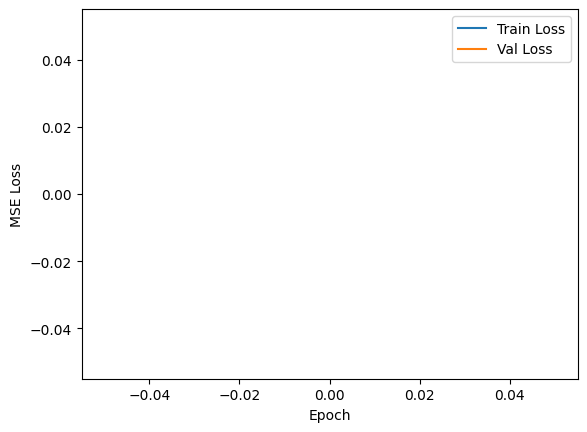

In [8]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


In [12]:
# Ensure the model has been called on some data
dummy_input = np.zeros((1, time_steps, n_features), dtype=np.float32)
_ = cnn_model(dummy_input)  # This should set up the model’s input

# Check if the input is now defined
print("Model input:", cnn_model.input)

# Now create the feature extractor
feature_extractor = Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer('flatten_layer').output
)

# Extract features
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

print("Extracted train features shape:", X_train_features.shape)
print("Extracted test features shape:", X_test_features.shape)


AttributeError: The layer sequential has never been called and thus has no defined input.